# Building the prediction model with PCA run dataframe and Random Forest

This is an alternative model being explored where the features are principal components derived from the initial workbook. This will be used to compare performance of the logistic regression model which was developed first for more interpretability

## imports

In [8]:
# import pca_run_prem
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# df = pd.read_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/pca_run_prem_v2.csv')

v3 = pd.read_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/pca_run_prem_v3.csv')

# V3
- Stadium code added
- Manager code
- More of the feature engineered columns to be looked at

In [9]:
v3.sample(3)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,home_avg_rating,away_avg_rating,best_home_player_rating,best_away_player_rating,home_net_goals,away_net_goals
1560,2012-11-24,Villa Park,13,Aston Villa,Paul Lambert,0,0,Arsenal,Arsène Wenger,0,...,4,1.58,7,-3,59.5,67.2,77.0,86.0,-0.42,0.83
2508,2014-08-31,White Hart Lane,3,Tottenham Hotspur,Mauricio Pochettino,0,3,Liverpool,Brendan Rodgers,-1,...,6,1.50,3,3,66.0,64.4,79.0,88.5,0.40,0.64
2877,2016-03-05,White Hart Lane,29,Tottenham Hotspur,Mauricio Pochettino,2,2,Arsenal,Arsène Wenger,0,...,12,1.82,7,5,61.5,68.1,73.0,86.0,0.40,0.83


In [10]:
v3.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'season', 'Home ID',
       'Away ID', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_avg_rating', 'away_avg_rating',
       'best_home_player_rating', 'best_away_player_rating', 'home_net_goals',
       'away_net_goals'],
      dtype='object')

In [11]:
# Drop Venue, we have Venue Code
v3.drop('Venue', axis=1, inplace=True)

# Drop Home Manager and Away Manager, we have Manager Code
v3.drop(['Home Manager', 'Away Manager'], axis=1, inplace=True)

# Drop Day, we have day code
v3.drop('Day', axis=1, inplace=True)

# Drop Home Team and Away Team, we have team ID
v3.drop(['home_team', 'away_team'], axis=1, inplace=True)

# Drop season
v3.drop('season', axis=1, inplace=True)

In [19]:
rf = RandomForestClassifier(
    n_estimators=50, 
    min_samples_split=10, # the number of records before we split a node - e.g. a specific stadium / manager,
    random_state=42)


## Time Series Data

We are training our model on past matches, to be able to predict future ones, so training data should be dated before testing data. If we still aim for around 20-25% testing data then that gives us the last two seasons, which would begin around August 2014. This way:

- Our training data is seasons 2008-09, 09-10, 10-11, 11-12, 12-13, 13-14
- Our testing data is seasons 2014-15 and 2015-16

In [12]:
train = v3[v3['date'] < '2014-08-01']
test = v3[v3['date'] >= '2014-08-01']

In [18]:
test.shape[0] / v3.shape[0]

0.25

## Predictors for V3

In [20]:
v3.columns

Index(['date', 'Gameweek / 38', 'Home GF', 'Away GF', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'Home ID', 'Away ID',
       'Venue Code', 'Home Manager Code', 'Away Manager Code', 'Day Code',
       'home_team_ppg', 'away_team_ppg', 'home_ppg_season', 'home_pts_last_5',
       'away_ppg_season', 'away_pts_last_5', 'pts_last_5_diff',
       'home_avg_rating', 'away_avg_rating', 'best_home_player_rating',
       'best_away_player_rating', 'home_net_goals', 'away_net_goals'],
      dtype='object')

Let's use the venue code and manager codes and the Day codes, in addition to the recent form points in the last 5

Scaling isn't necessary because of the threshold based interpretation of the Random Forest algorithm.

In [33]:
features = ['Venue Code', 'Home ID', 'Away ID', 'Home Manager Code', 'Away Manager Code', 'Day Code', 'home_pts_last_5', 'away_pts_last_5']
target = ['Home Win']

## Training the Model - Predicting a home win or not

In [34]:
rf.fit(v3[features], v3[target])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=42)

## Predictions & Evaluation

In [35]:
preds = rf.predict(test[features])

In [36]:
# Accuracy score
print(accuracy_score(test[target], preds))

# classification report
print(classification_report(test[target], preds))

0.9355263157894737
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       431
           1       0.93      0.92      0.92       329

    accuracy                           0.94       760
   macro avg       0.94      0.93      0.93       760
weighted avg       0.94      0.94      0.94       760



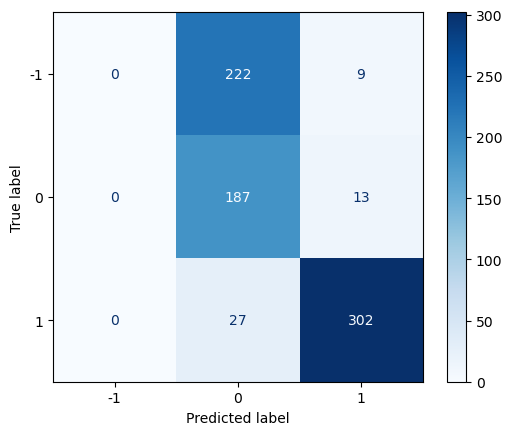

In [44]:
# confusion Matrix
cm = confusion_matrix(test[target], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)


These are amazing results compared to the prior run! The Precision/Recall score is balanced nicely despite a slight class imbalance of more Draws or Away wins than Home wins.

From a percentage standpoint we were stronger at predicting a game would not be a Home win (409/431) than it would (302 / 329) but its both in the low 90% range.

I will try the Win/Draw/Loss now

## Predicting Home Win/ Draw / Away Win

In [38]:
features = ['Venue Code', 'Home ID', 'Away ID', 'Home Manager Code', 'Away Manager Code', 'Day Code', 'home_pts_last_5', 'away_pts_last_5']
target = ['Result']

In [39]:
rf.fit(v3[features], v3[target])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=42)

In [40]:
preds_wdl = rf.predict(test[features])

### Home/Draw/Away - Model Evaluation

In [42]:
# Accuracy score
print(accuracy_score(test[target], preds_wdl))

# classification report
print(classification_report(test[target], preds_wdl))

0.8828947368421053
              precision    recall  f1-score   support

          -1       0.94      0.83      0.88       231
           0       0.98      0.78      0.87       200
           1       0.82      0.99      0.89       329

    accuracy                           0.88       760
   macro avg       0.91      0.86      0.88       760
weighted avg       0.90      0.88      0.88       760



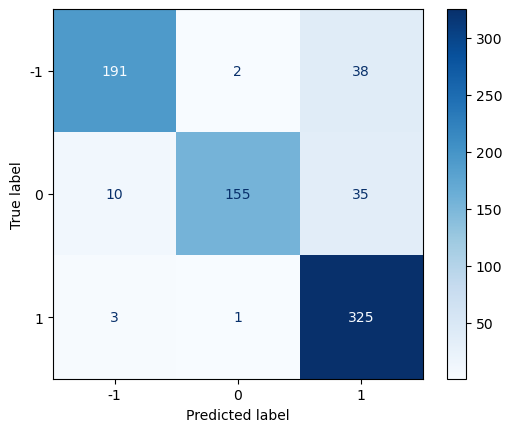

In [45]:
# confusion matrix 
cm = confusion_matrix(test[target], preds_wdl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)


These are incredible results compared to the 52% I was finding before in V2. I do not know exactly what prompted the huge uptick. Whether the time series fix for the training/testing dataset helped, or the venue codes (recognizing the importance of some teams' home performance) balanced with recent form and a particular manager gave enough rules for a RF classifier to break through.

We still see a slight tendency towards predicting home wins rather than draws or losses as we saw in V1 and 2.

## V2

In [17]:
df.sample(5)

,PC1,PC2,PC3,PC4,p(Home),p(Draw),p(Away),Result
2964,0.005641,-0.282010,-1.129980,0.930118,0.457,0.258,0.285,1
1895,-0.403886,0.500769,-0.961058,-0.194123,0.457,0.258,0.285,1
2657,-0.857472,-0.891843,-0.075507,0.028527,0.457,0.258,0.285,-1
1584,-2.036530,0.256216,-0.330386,-0.645570,0.457,0.258,0.285,1
1453,-2.132244,1.370095,-1.306988,1.773362,0.457,0.258,0.285,1


## Train the model

In [18]:
# Step 1: Split data into features (X) and target (y)
X_pca = df.drop('Result', axis=1)
y_pca = df['Result']

In [19]:
# Step 2: Train-test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

In [20]:
# Step 3: Train Random Forest Classifier
rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=100,  # Number of trees
    max_depth=5,       # Limit depth of each tree (same as decision tree for comparability)
    n_jobs=-1          # Use all available CPU cores for training
)
rf_model.fit(X_train_pca, y_train_pca)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

In [21]:
# Step 4: Evaluate the Random Forest Model
y_pred_pca_rf = rf_model.predict(X_test_pca)

In [23]:
# Accuracy and classification report
print("PCA Run Random Forest:")
print("Accuracy:", accuracy_score(y_test_pca, y_pred_pca_rf))
print(classification_report(y_test_pca, y_pred_pca_rf))

PCA Run Random Forest:
Accuracy: 0.5164473684210527
              precision    recall  f1-score   support

          -1       0.49      0.49      0.49       177
           0       0.60      0.02      0.04       152
           1       0.53      0.80      0.64       279

    accuracy                           0.52       608
   macro avg       0.54      0.44      0.39       608
weighted avg       0.53      0.52      0.44       608



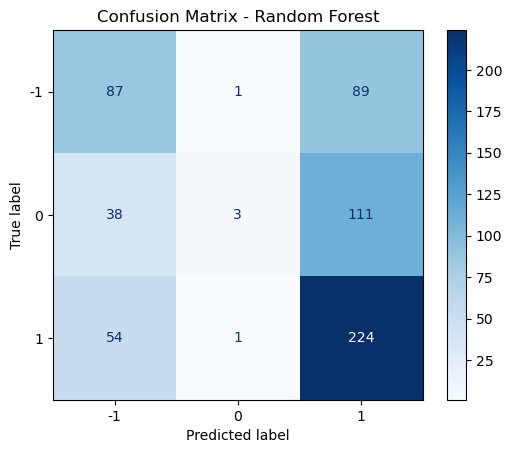

In [22]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_pca, y_pred_pca_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [26]:
# print the cm
print(cm_pca_tree)


[[194   9  76]
 [ 79   5  68]
 [ 69   1 107]]


## Initial analysis

V2

__________


V1

With chance being 0.33, the initial performance of 50.33% is slightly worse than the logistic regression but its performance differs in that:
- It is slightly stronger in predicting away wins
- It is slightly weaker in predicting home wins
- It is willing to bet on draws occurring

The recall scores being higher than the precision scores shows that we will get a lot of false positives for the home win or away win.

However...**it is struggling with draws**

### V2 Feature importance


In [24]:
importances = rf_model.feature_importances_
feature_names = X_pca.columns
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

PC1: 0.1748
PC2: 0.5453
PC3: 0.1287
PC4: 0.1511
p(Home): 0.0000
p(Draw): 0.0000
p(Away): 0.0000


PC2 is clearly the most important feature contributing to predictions here, From the loadings in the previous workbook, this is the PC most related to differences between the home and away team.

PC1 has a lot of variance too and it is the next most important feature but less than 1/3 as important as PC2.